# Análise Estatística dos Discursos do Senado (56ª Legislatura)

Este notebook examina o conjunto de discursos proferidos no Senado Federal durante a 56ª Legislatura.

Principais objetivos:
- compreender a composição do acervo (autores, partidos, datas e metadados)
- identificar padrões temporais de produção de discursos
- analisar o tamanho dos textos e a distribuição de temas (tipos de uso da palavra)
- gerar sumários numéricos e visuais que sirvam de base para estudos posteriores

## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datasets import load_dataset
from datasets import load_dataset_builder

## Configurar bibliotecas

In [4]:
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='tab10')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## Inicializar variáveis

In [5]:
DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
SPLIT="train"
DATA_FILE_HF = {f"{SPLIT}": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

## Verificar estrutura do dataset

In [7]:
ds_builder = load_dataset_builder(DATASET_HF_REPO)

ds_builder.info

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('string'), 'CodigoPronunciamento': Value('string'), 'Casa': Value('string'), 'Data': Value('string'), 'Resumo': Value('string'), 'Indexacao': Value('string'), 'TextoIntegral': Value('string'), 'TextoIntegralTxt': Value('string'), 'UrlTextoBinario': Value('string'), 'TipoAutor': Value('string'), 'FuncaoAutor': Value('string'), 'NomeAutor': Value('string'), 'CodigoParlamentar': Value('string'), 'Partido': Value('string'), 'UF': Value('string'), 'TipoUsoPalavra.Codigo': Value('string'), 'TipoUsoPalavra.Sigla': Value('string'), 'TipoUsoPalavra.Descricao': Value('string'), 'TipoUsoPalavra.IndicadorAtivo': Value('string'), 'Publicacoes.Publicacao': List({'DataPublicacao': Value('string'), 'FontePublicacao': Value('string'), 'PaginaFinal': Value('string'), 'PaginaInicial': Value('string'), 'SiglaFonte': Value('string'), 'TipoPublicacao': Value('string'), 'UrlDiario': Value('string')}), 'Apartes.Aparteante'

## Analisar estrutura

In [8]:
dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df = dataset[SPLIT].to_pandas()

print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')
df.head(3)

Linhas: 15729 | Colunas: 30


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,FuncaoAutor,NomeAutor,CodigoParlamentar,Partido,UF,TipoUsoPalavra.Codigo,TipoUsoPalavra.Sigla,TipoUsoPalavra.Descricao,TipoUsoPalavra.IndicadorAtivo,Publicacoes.Publicacao,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Ciro Nogueira,739,PP,PI,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-02-28', 'FontePublic...",None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Paulo Paim,825,PT,RS,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-02-28', 'FontePublic...",None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Wellington Fagundes,1173,PR,MT,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-02-28', 'FontePublic...",None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,


In [18]:
overview = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'missing': df.isna().sum()
}).sort_values('missing', ascending=False)
overview

,dtype,missing
PaisAutor,object,15632
OrgaoAutor,object,14918
Apartes.Aparteante,object,14861
CargoAutor,object,14825
Partido,object,2074
CodigoParlamentar,object,2074
UF,object,2074
Publicacoes.Publicacao,object,734
Resumo,object,57
Indexacao,object,35


## Tratar campo data
Criar campos para ano, mês e dia da semana

In [19]:
date_cols = ['Data']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['ano'] = df['Data'].dt.year
df['mes'] = df['Data'].dt.to_period('M')

dias_map = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

df['dia_semana'] = df['Data'].dt.day_name().map(dias_map)

df[["Data", "ano", "mes", "dia_semana"]].head()

,Data,ano,mes,dia_semana
0,2019-02-27,2019,2019-02,Quarta-feira
1,2019-02-27,2019,2019-02,Quarta-feira
2,2019-02-27,2019,2019-02,Quarta-feira
3,2019-02-27,2019,2019-02,Quarta-feira
4,2019-02-27,2019,2019-02,Quarta-feira


## Visualizar quantidade de discursos por ano

,ano,qtd_discursos
0,2019,3686
1,2020,1518
2,2021,5503
3,2022,4988
4,2023,34


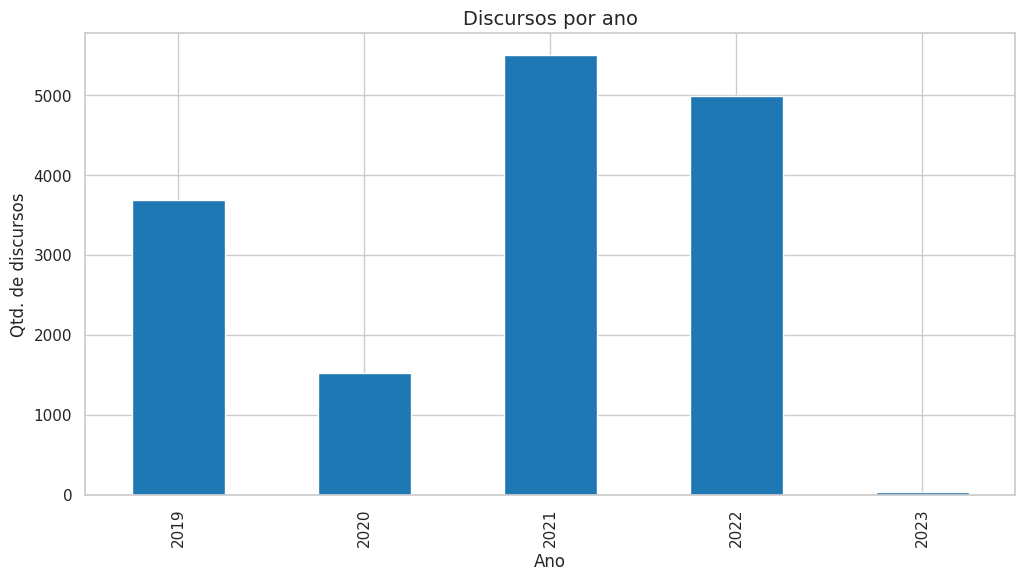

In [20]:
discursos_por_ano = (df.groupby(["ano"])
                     .size()
                     .reset_index(name="qtd_discursos")
                    )

ax = discursos_por_ano.plot(x="ano", y="qtd_discursos", kind="bar", legend=False)
ax.set_title("Discursos por ano")
ax.set_xlabel("Ano")
ax.set_ylabel("Qtd. de discursos")

discursos_por_ano

## Visualizar quantidade de discursos por mês

mes
2022-09    104
2022-10    230
2022-11    244
2022-12    706
2023-01     34
Freq: M, Name: discursos, dtype: int64

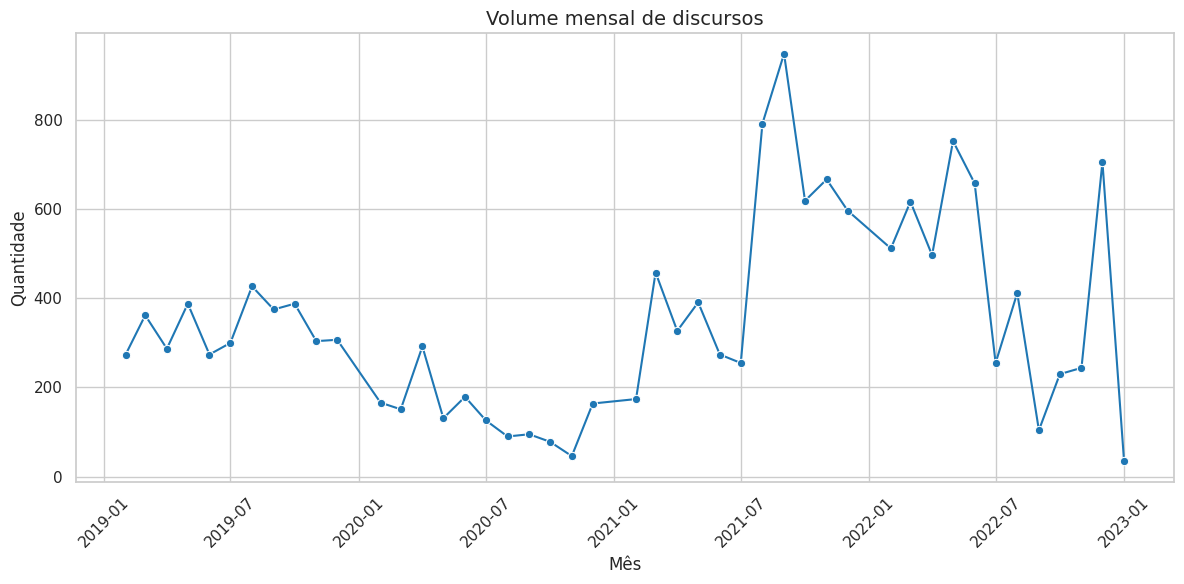

In [21]:
discursos_por_mes = (
    df.dropna(subset=['mes'])
      .groupby('mes')
      .size()
      .rename('discursos')
      .sort_index()
)

fig, ax = plt.subplots()
sns.lineplot(x=discursos_por_mes.index.to_timestamp(), y=discursos_por_mes.values, marker='o', ax=ax)
ax.set(title='Volume mensal de discursos', xlabel='Mês', ylabel='Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
discursos_por_mes.tail()

## Tratar campos texto

Todos as colunas vazias devem conter uma string vazia

In [22]:
text_columns = [
    'Resumo', 'Indexacao', 'TextoIntegral', 'TextoIntegralTxt',
    'TextoDiscursoIntegral', 'TipoUsoPalavra.Descricao', 'TipoUsoPalavra.Sigla',
    'TipoUsoPalavra.Codigo', 'TipoUsoPalavra.IndicadorAtivo',
    'Publicacoes.Publicacao', 'Apartes.Aparteante', 'CargoAutor',
    'OrgaoAutor', 'PaisAutor'
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna('').astype(str)

df[df['TextoDiscursoIntegral'] == '']

,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,FuncaoAutor,NomeAutor,CodigoParlamentar,Partido,UF,TipoUsoPalavra.Codigo,TipoUsoPalavra.Sigla,TipoUsoPalavra.Descricao,TipoUsoPalavra.IndicadorAtivo,Publicacoes.Publicacao,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg,ano,mes,dia_semana
1607,455207,455207,Congresso Nacional,2019-06-11,Considerações sobre a importância para o País ...,"COMENTARIO, IMPORTANCIA, APROVAÇÃO, PROJETO DE...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Marcelo Castro,742,MDB,PI,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-06-13', 'FontePublic...",,2019-06-05,2019-07-05,,,,,False,404,404 (sem texto integral),2019,2019-06,Terça-feira
2803,461050,461050,Senado Federal,2019-11-01,"Defesa de uma reforma tributária, em tramitaçã...","DEFESA, REFORMA TRIBUTARIA, TRAMITAÇÃO, CONGRE...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Confúcio Moura,475,MDB,RO,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-11-02', 'FontePublic...",,2019-10-07,2019-11-06,,,,,False,404,404 (sem texto integral),2019,2019-11,Sexta-feira
3365,462708,462708,Congresso Nacional,2019-11-19,Encerramento da Sessão Solene destinada a come...,"ENCERRAMENTO, SESSÃO SOLENE, DESTINAÇÃO, COMEM...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Jorginho Mello,5350,PL,SC,4824,FP,Fala da Presidência,Sim,"[{'DataPublicacao': '2019-11-21', 'FontePublic...",,2019-11-07,2019-12-07,,,,,False,404,404 (sem texto integral),2019,2019-11,Terça-feira
3366,462707,462707,Congresso Nacional,2019-11-19,Sessão Solene destinada a comemorar a Semana G...,"SESSÃO SOLENE, DESTINAÇÃO, COMEMORAÇÃO, SEMANA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Autor Externo,EXTERNO,CARLOS ALEXANDRE DA COSTA,None,None,None,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-11-21', 'FontePublic...",,2019-11-07,2019-12-07,,,,,False,404,404 (sem texto integral),2019,2019-11,Terça-feira
3367,462705,462705,Congresso Nacional,2019-11-19,Sessão Solene destinada a comemorar a Semana G...,"SESSÃO SOLENE, DESTINAÇÃO, COMEMORAÇÃO, SEMANA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Autor Externo,EXTERNO,ALCIDE ANDRADE,None,None,None,4819,DIS,Discurso,Sim,"[{'DataPublicacao': '2019-11-21', 'FontePublic...",,2019-11-07,2019-12-07,,,,,False,404,404 (sem texto integral),2019,2019-11,Terça-feira
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,484317,484317,Senado Federal,2021-09-21,"Orientação à bancada, pela Liderança do Govern...","ORIENTAÇÃO, BANCADA, PROPOSTA DE EMENDA A CONS...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Fernando Bezerra Coelho,5540,MDB,PE,11338,POB,Orientação à bancada,Sim,"[{'DataPublicacao': '2021-09-22', 'FontePublic...",,2021-09-19,2021-10-19,,,,,False,404,404 (sem texto integral),2021,2021-09,Terça-feira
9089,484315,484315,Senado Federal,2021-09-21,"Orientação à bancada, pelo Partido PROS, sobre...","ORIENTAÇÃO, BANCADA, PROPOSTA DE EMENDA A CONS...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),SENADOR,Telmário Mota,5535,PROS,RR,11338,P

## Contar palavras e caracteres do discurso

In [23]:

df['texto_len_palavras'] = df['TextoDiscursoIntegral'].str.split().str.len()
df['texto_len_caracteres'] = df['TextoDiscursoIntegral'].str.len()
df['resumo_len_palavras'] = df['Resumo'].str.split().str.len()

df[['id', 'texto_len_palavras', 'texto_len_caracteres', 'resumo_len_palavras']].head()

,id,texto_len_palavras,texto_len_caracteres,resumo_len_palavras
0,451286,873,5650,46
1,451285,1588,10113,31
2,451205,4682,28440,57
3,451203,3515,20792,17
4,451202,5774,35028,22


## Separar dados faltantes

In [24]:
missing = (
    df.isna()
      .sum()
      .to_frame('faltantes')
      .assign(percentual=lambda s: (s['faltantes'] / len(df) * 100).round(2))
      .sort_values('faltantes', ascending=False)
)
missing.head(10)

,faltantes,percentual
UF,2074,13.19
CodigoParlamentar,2074,13.19
Partido,2074,13.19
id,0,0.00
Data,0,0.00
Casa,0,0.00
CodigoPronunciamento,0,0.00
Resumo,0,0.00
UrlTextoBinario,0,0.00
Indexacao,0,0.00


## Analisar métricas do dataset

In [26]:
metrics = pd.Series({
    'Discursos': len(df),
    'Autores únicos': df['NomeAutor'].nunique(),
    'Partidos únicos': df['Partido'].nunique(),
    'UFs representadas': df['UF'].replace('', np.nan).nunique(dropna=True),
    'Funções de autor únicas': df['FuncaoAutor'].replace('', np.nan).nunique(dropna=True),
    'Discursos com resumo': int((df['Resumo'].str.len() > 0).sum()),
    'Discursos com indexação': int((df['Indexacao'].str.len() > 0).sum()),
    'Discursos com texto integral': int((df['TextoDiscursoIntegral'].str.len() > 0).sum())
}).to_frame('quantidade')
metrics

,quantidade
Discursos,15729
Autores únicos,1794
Partidos únicos,32
UFs representadas,27
Funções de autor únicas,3
Discursos com resumo,15672
Discursos com indexação,15666
Discursos com texto integral,15039


## Visualizar discursos por autor

,NomeAutor,discursos
0,Izalci Lucas,704
1,Paulo Paim,676
2,Eduardo Girão,593
3,Rodrigo Pacheco,496
4,Jorge Kajuru,458
5,Esperidião Amin,409
6,Zenaide Maia,398
7,Jean-Paul Prates,355
8,Paulo Rocha,332
9,Nelsinho Trad,311


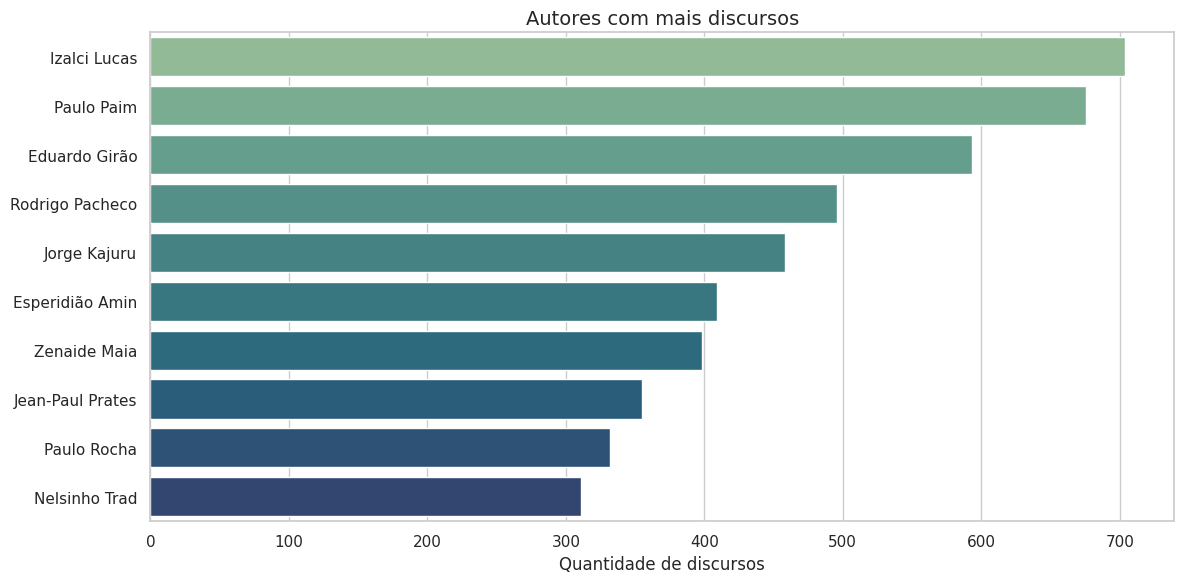

In [27]:
discursos_por_autor = (
    df.groupby('NomeAutor')
      .size()
      .sort_values(ascending=False)
      .head(10)
      .rename('discursos')
      .reset_index()
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=discursos_por_autor, y='NomeAutor', x='discursos', hue='NomeAutor', ax=ax, palette='crest')
ax.set(title='Autores com mais discursos', xlabel='Quantidade de discursos', ylabel='')
plt.tight_layout()
discursos_por_autor

## Discursos por partido

,Partido,discursos
0,PT,1890
1,PODEMOS,1743
2,MDB,1675
3,PSD,1330
4,PSDB,1179
5,PP,919
6,PL,832
7,DEM,779
8,PROS,548
9,CIDADANIA,511


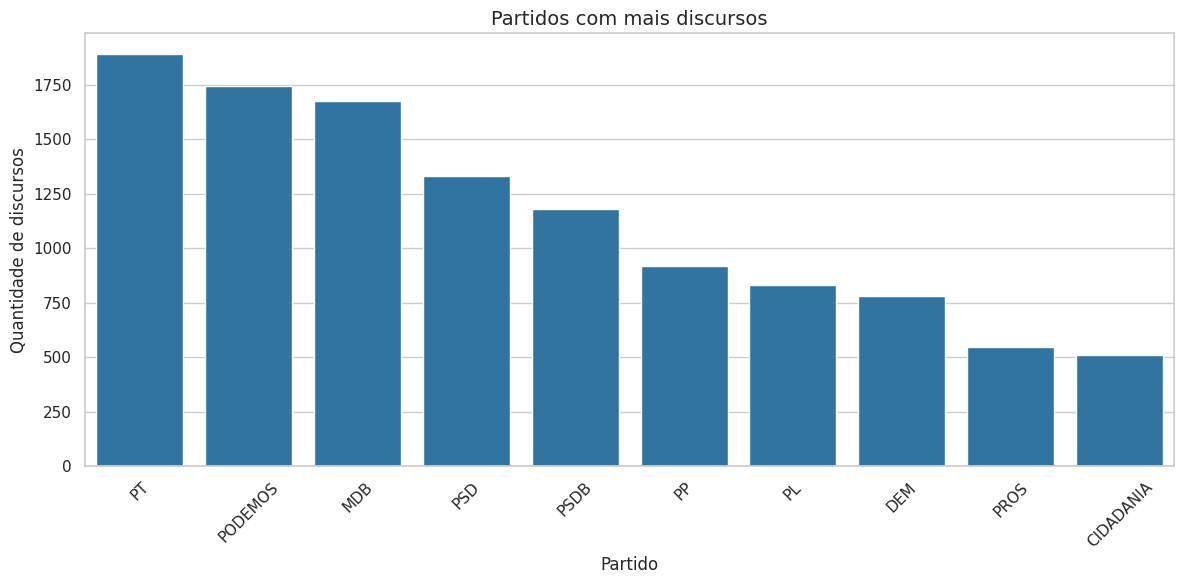

In [28]:
discursos_por_partido = (
    df.groupby('Partido')
      .size()
      .sort_values(ascending=False)
      .head(10)
      .rename('discursos')
      .reset_index()
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=discursos_por_partido, x='Partido', y='discursos', ax=ax)
ax.set(title='Partidos com mais discursos', xlabel='Partido', ylabel='Quantidade de discursos')
plt.xticks(rotation=45)
plt.tight_layout()
discursos_por_partido

## Discursos por UF

,UF,discursos
0,RS,1128
1,DF,1056
2,RN,839
3,MG,804
4,CE,708
5,MS,625
6,GO,619
7,MT,571
8,SC,565
9,PR,564


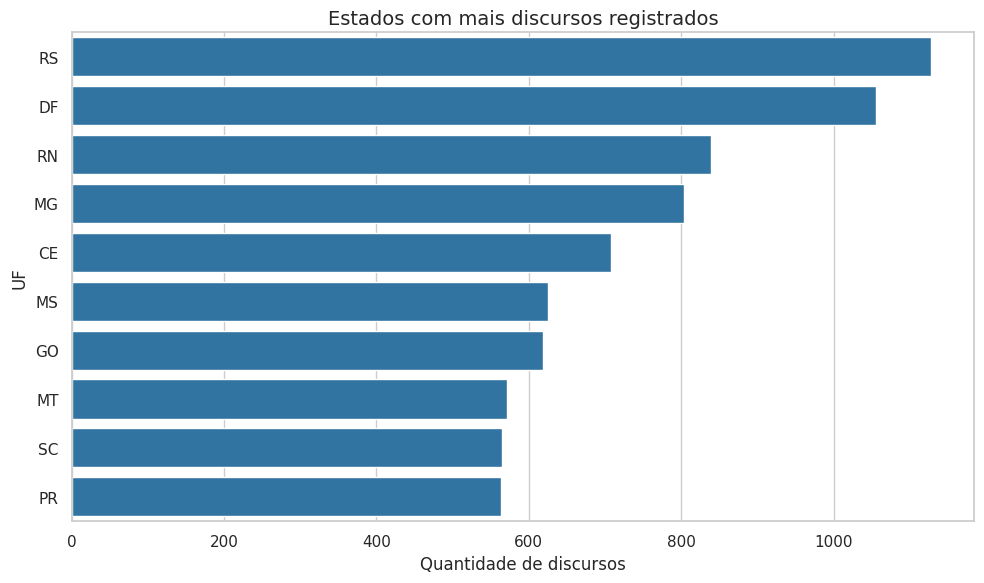

In [30]:
discursos_por_partido = (
    df['UF']
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'UF'})
)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=discursos_por_partido, x='discursos', y='UF', ax=ax)
ax.set(title='Estados com mais discursos registrados', xlabel='Quantidade de discursos', ylabel='UF')
plt.tight_layout()
discursos_por_partido

## Distribuição do tamanho dos discursos

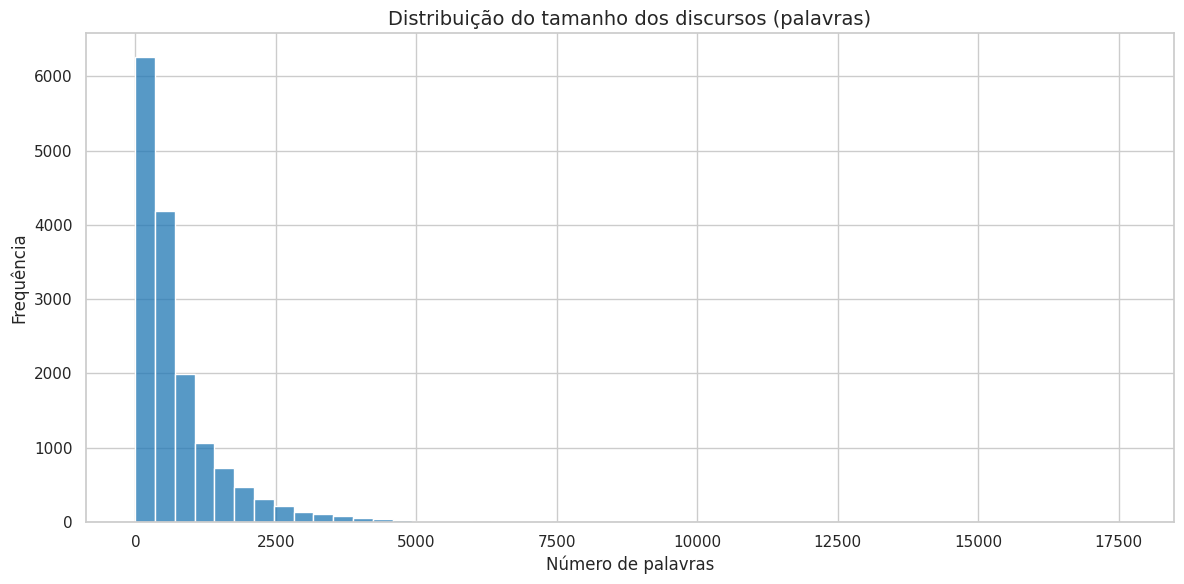

In [31]:
fig, ax = plt.subplots()
sns.histplot(df['texto_len_palavras'], bins=50, ax=ax)
ax.set(title='Distribuição do tamanho dos discursos (palavras)', xlabel='Número de palavras', ylabel='Frequência')
plt.tight_layout()

## Análise do tamanho do discurso

In [33]:
tamanho_discursos = pd.DataFrame({
    'palavras': df['texto_len_palavras'].describe().round(2),
    'caracteres': df['texto_len_caracteres'].describe().round(2)
})
tamanho_discursos

,palavras,caracteres
count,15729.00,15729.00
mean,727.83,4450.81
std,880.17,5326.02
min,0.00,0.00
25%,195.00,1201.00
50%,464.00,2842.00
75%,912.00,5595.00
max,17602.00,106610.00


In [ ]:
top_partidos_lista = top_parties['Partido']
heatmap_data = (
    df[df['Partido'].isin(top_partidos_lista)]
      .dropna(subset=['ano'])
      .groupby(['ano', 'Partido'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', linewidths=0.5, ax=ax)
ax.set(title='Participação anual por partido (top 10)', xlabel='Partido', ylabel='Ano')
plt.tight_layout()
heatmap_data

KeyError: 'Partido'

ValueError: Could not interpret value `Tipo de uso` for `y`. An entry with this name does not appear in `data`.

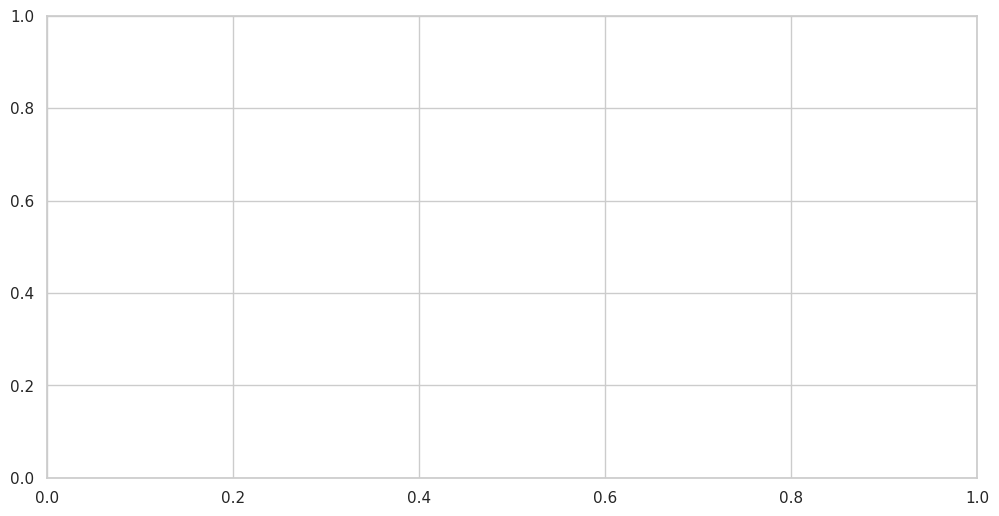

In [36]:
uso = (
    df['TipoUsoPalavra.Descricao']
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'Tipo de uso'})
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=uso, x='discursos', y='Tipo de uso', ax=ax)
ax.set(title='Principais tipos de uso da palavra', xlabel='Quantidade de discursos', ylabel='')
plt.tight_layout()
uso

In [ ]:
weekday_order = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
weekday_counts = (
    df.dropna(subset=['dia_semana'])
      .groupby('dia_semana')
      .size()
      .reindex(weekday_order, fill_value=0)
      .rename('discursos')
)
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, ax=ax)
ax.set(title='Distribuição de discursos por dia da semana', xlabel='Dia da semana', ylabel='Quantidade de discursos')
plt.tight_layout()
weekday_counts

## Principais achados

- Os discursos se concentram entre 2019 e 2022, com picos mensais próximos às sessões de maior atividade legislativa.
- Autores como os líderes partidários respondem pelo maior volume de pronunciamentos, e PT, Podemos e MDB aparecem como partidos mais prolíficos.
- A maioria dos discursos possui texto integral disponível, com mediana de aproximadamente 464 palavras (≈2,8 mil caracteres) e cauda longa que indica pronunciamentos extensos.
- Tipos de uso da palavra relacionados a relatorias e lideranças dominam o plenário, reforçando o papel institucional desses cargos.
- A distribuição semanal mostra concentração entre terça e quinta-feira, dias tradicionalmente destinados às deliberações no Senado.